In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2

joblib is not installed. Falling back to sequential computation.


In [2]:
pdb = md.load_pdb('./1bna.pdb')
#res = pdb.atom_slice(pdb.top.select('resid 0 23'))
res = pdb.atom_slice(pdb.top.select('resid 1'))
view = nv.show_mdtraj(res)
view

NGLWidget()

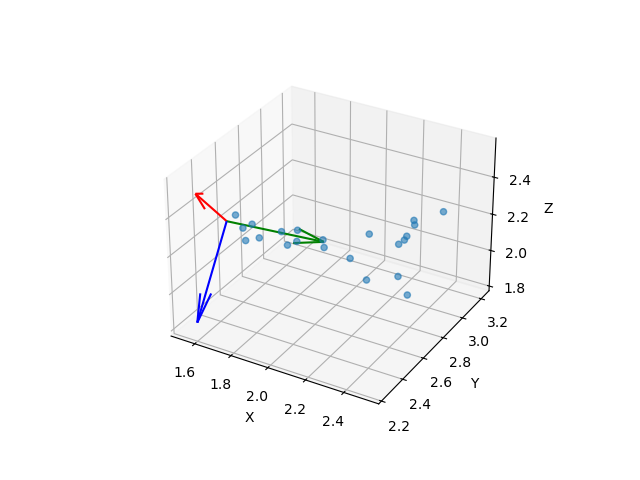

In [3]:
%matplotlib ipympl
ref = mdna.ReferenceBase(res)
ref.plot_baseframe(length=0.5)    

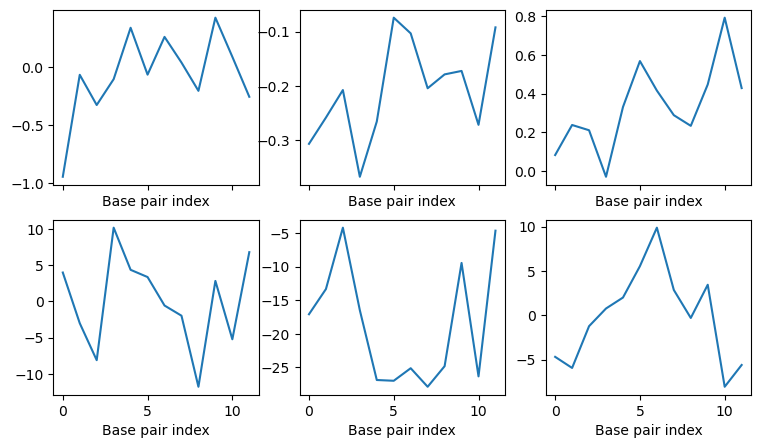

In [251]:
import numpy as np
#import quaternion  # Import the numpy-quaternion extension
import quaternionic as quaternion

def extract_transform(frame):
    """ Extract translation vector and rotation matrix from the frame """
    translation = frame[0]
    rotation_matrix = frame[1:].T # transpose to define rotation matrix as column vectors
    return translation, rotation_matrix

def interpolate_frames(frame_a, frame_b, t=0.5):
    # Extract translation and rotation from both frames
    trans_a, rot_a = extract_transform(frame_a)
    trans_b, rot_b = extract_transform(frame_b)
    
    # Convert rotation matrices to quaternions
    quat_a = quaternion.array.from_rotation_matrix(rot_a)
    quat_b = quaternion.array.from_rotation_matrix(rot_b)
    
    # get translation between a and b
    trans_mid = trans_a - trans_b  

    # Slerp (spherical linear interpolation) for quaternion
    # Note that output slerp(q1, q2, 1) may be different from q2. (slerp(q1, q2, 0) is always equal to q1.)
    quat_interpolated = quaternion.slerp(quat_a, quat_b, tau=t).normalized

    # Convert quaternion to rotation matrix
    G = quat_interpolated.to_rotation_matrix  
    T = np.dot(G.T, trans_mid)*10 # convert to angstroms

    # Relative rotation matrix
    A = np.dot(rot_b.T, rot_a)
    
    # Cayley transform vector
    R = 2 * np.array([
        A[2, 1] - A[1, 2],
        A[0, 2] - A[2, 0],
        A[1, 0] - A[0, 1]
    ]) / (np.trace(A) + 1)

    # Lets do the quaternion analogue of getting the relative rotation matrix
    Aq =  quat_b.inverse * quat_a
    # Get axis angle representation of the relative rotation matrix
    # Each vector represents the axis of the rotation, with norm equal to the angle of the rotation in radians.
    Rq = Aq.to_axis_angle 
    
    return T, Rq

%matplotlib inline
pdb = md.load_pdb('./1bna.pdb')
nuc = mdna.NucleicFrames(pdb)
sequence = ''.join(mdna.get_sequence_letters(pdb))
params, names = nuc.get_parameters()
frames = nuc.frames

T, R = [], []
for idx in range(0, len(sequence)):
    res_a,res_b = nuc.res_A[idx], nuc.res_B[idx]
    frame_a, frame_b = frames[res_a][0], frames[res_b][0]
    frame_b[[2,3]] *= -1
    trans, euler = interpolate_frames(frame_a, frame_b, t=0.5)
    T.append(trans)
    R.append(euler)


T = np.array(T)
R = np.array(R)

fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=True, sharey=False)
ax = ax.flatten()

# plot translation
for i in range(3):
    ax[i].plot(T[:, i])
   # ax[i].set_ylabel(f'Translation {i}')
    ax[i].set_xlabel('Base pair index')
# plot rotation
for i in range(3):
    ax[i+3].plot(np.rad2deg(R[:, i]))
    #ax[i+3].set_ylabel(f'Euler angle {i}')
    ax[i+3].set_xlabel('Base pair index')

(1, 12, 3) (1, 12, 3)


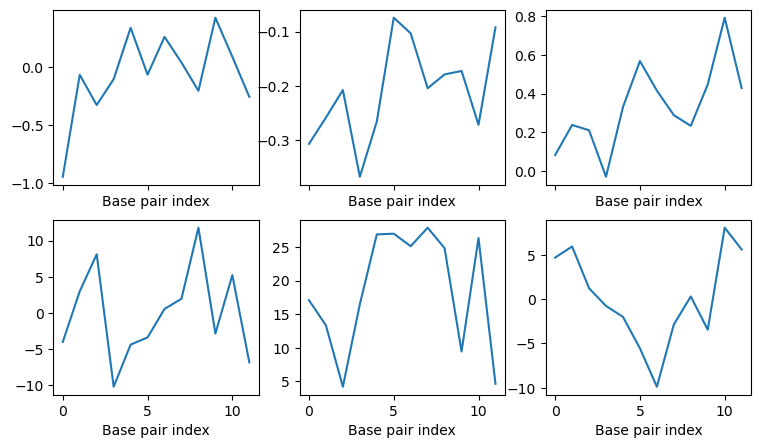

In [259]:
import numpy as np
#import quaternion  # Import the numpy-quaternion extension
import quaternionic as quaternion

def extract_transforms(frame):
    """ Extract translations and rotation matrices from frames in batch """
    translations =  frame[:,0]  # extract translations
    rotation_matrices = frame[:,1:].transpose(0, 2, 1) # extract rotation matrices
    return translations, rotation_matrices


def interpolate_frames(frame_a, frame_b, t=0.5):
    #print('1frames',frame_a.shape, frame_b.shape)

    # Extract translation and rotation from both frames
    trans_a, rot_a = extract_transforms(frame_a)
    trans_b, rot_b = extract_transforms(frame_b)
  
    quat_a = quaternion.array.from_rotation_matrix(rot_a)
    quat_b = quaternion.array.from_rotation_matrix(rot_b)
    
    # get translation between a and b
    trans_mid = trans_a - trans_b  

    # Slerp (spherical linear interpolation) for quaternion
    quat_interpolated = quaternion.slerp(quat_a, quat_b, tau=t)

    # Convert quaternion to rotation matrix
    G = quat_interpolated.to_rotation_matrix  
    
    # Get translational coordinate vector and convert to angstroms
    T = np.einsum('ijk,ik->ij', G.transpose(0,2,1), trans_mid)*10
    
    # Relative rotation matrix
    A = np.einsum('ijk,ikl->ijl', rot_b.transpose(0,2,1), rot_a)
    
    # Cayley transform vector to get rotational coordinate vector
    R = 2 * np.array([
        A[:,2, 1] - A[:,1, 2],
        A[:,0, 2] - A[:,2, 0],
        A[:,1, 0] - A[:,0, 1]
    ]).T / (np.trace(A, axis1=1, axis2=2) + 1)[:,None]

    # Lets do the quaternion analogue of getting the relative rotation matrix
    #Aq =  quat_b.inverse * quat_a
    b = quat_b.to_rotation_matrix 
    a = quat_a.to_rotation_matrix
    Aq = quaternion.array.from_rotation_matrix(np.einsum('ijk,ikl->ijl', a.transpose(0,2,1), b))
    # print(a.shape,b.shape)
    # Aq = quaternion.array.from_rotation_matrix(Aq)
    # Get axis angle representation of the relative rotation matrix
    # Each vector represents the axis of the rotation, with norm equal to the angle of the rotation in radians.
    Rq = Aq.to_axis_angle 
    
    return T, Rq

%matplotlib inline

pdb = md.load_pdb('./1bna.pdb')
sequence = ''.join(mdna.get_sequence_letters(pdb))
params, names = nuc.get_parameters()
frames = nuc.frames

T, R = [], []
for idx in range(0, len(sequence)):
    res_a,res_b = nuc.res_A[idx], nuc.res_B[idx]
    frame_a, frame_b = frames[res_a], frames[res_b]
    frame_b[:,[2,3]] *= -1
    #print('0frames',frame_a.shape, frame_b.shape)
    trans, rot = interpolate_frames(frame_a, frame_b, t=0.5)
    T.append(trans)
    R.append(rot)


T = np.array(T).swapaxes(0,1)
R = np.array(R).swapaxes(0,1)
print(T.shape, R.shape)
T = T[0]
R = R[0]



fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=True, sharey=False)
ax = ax.flatten()

# plot translation
for i in range(3):
    ax[i].plot(T[:, i])
   # ax[i].set_ylabel(f'Translation {i}')
    ax[i].set_xlabel('Base pair index')
# plot rotation
for i in range(3):
    ax[i+3].plot(np.rad2deg(R[:, i]))
    #ax[i+3].set_ylabel(f'Euler angle {i}')
    ax[i+3].set_xlabel('Base pair index')

In [817]:
import numpy as np
#import quaternion  # Import the numpy-quaternion extension
# angle wrap potential solution: https://forum.unity.com/threads/quaternion-how-to-compute-delta-angle-for-each-axis.242208/
import quaternionic as quaternion

def to_axis_angle2(quaternion):
    quaternion = quaternion.normalized
    print('norm',quaternion.normalized)
    print('quaternion',quaternion.shape, quaternion)
    v = quaternion.vector
    w = quaternion.w
    # Compute the angle (2 * arctan2(norm(v), w))
    sin_theta = np.linalg.norm(v, axis=1)
    angles = 2 * np.arctan2(sin_theta, w)
    angles = 2 * np.arccos(quaternion.w)
    angles = np.arctan2(sin_theta,w)
    axis_angle = 2 * np.log(quaternion.normalized).vector
    # print('axis_angle',axis_angle.shape, axis_angle)    
    # print('angles',angles, 2 * np.arccos(quaternion.w) % (2 * np.pi))
    # # Handle small angles separately to avoid division by zero
    # small_angle = sin_theta < np.finfo(float).eps
    # #print(v.shape, sin_theta.shape)
    # #axes = v / sin_theta
    # axes = np.zeros_like(v)
    # axes[~small_angle] = v[~small_angle] / sin_theta[~small_angle, np.newaxis]
    # axes[small_angle] = v[small_angle]  # Default axis direction for very small angles
    # #print('axes',axes.shape, axes)
    # # Multiply each axis by its corresponding angle
    # axis_angle = axes * angles[:, np.newaxis]
    return axis_angle
        
def extract_transforms(frame, step=False):
    """ Extract translations and rotation matrices from frames in batch """
    if not step:
        translations =  frame[:,0]  # extract translations
        rotation = frame[:,1:].transpose(0, 2, 1) # extract rotation matrices
    else:
        translations = frame[0]
        rotation = frame[1]
        #print(translations.shape, rotation.shape, type(translations), type(rotation))
    return translations, rotation

def to_constrained_axis_angle(quaternion):
    axis_angle = 2 * np.log(quaternion.normalized).vector
    # Normalize angle to be within -pi to pi
    angle = np.linalg.norm(axis_angle) 
    angle_mod = np.mod(angle + np.pi, 2 * np.pi) - np.pi
    axis_normalized = axis_angle / np.linalg.norm(axis_angle)
    constrained_axis_angle = angle_mod * axis_normalized
    return constrained_axis_angle


def interpolate_frames(frame_a, frame_b, t=0.5, cayley=False, step=False):
    #print('1frames',frame_a.shape, frame_b.shape)

    # Extract translation and rotation from both frames
    trans_a, rot_a = extract_transforms(frame_a, step)
    trans_b, rot_b = extract_transforms(frame_b, step)
    
    if not step:
        if rot_a.shape[0] > 0:
            print('unflipping rotors')
            quat_a = quaternion.unflip_rotors(quaternion.array.from_rotation_matrix(rot_a))
            quat_b = quaternion.unflip_rotors(quaternion.array.from_rotation_matrix(rot_b))
        else:
            quat_a = quaternion.array.from_rotation_matrix(rot_a)
            quat_b = quaternion.array.from_rotation_matrix(rot_b)

    else:
        if rot_a.shape[0] > 0:
            print('unflipping rotors')
            quat_a = quaternion.unflip_rotors(quaternion.array(rot_a))
            quat_b = quaternion.unflip_rotors(quaternion.array(rot_b))
        else:
            quat_a = quaternion.array(rot_a)
            quat_b = quaternion.array(rot_b)
            
    # Get translation between a and b
    if not step:
        trans = trans_a - trans_b  
    else:
        trans = trans_b - trans_a


    # Linear interpolation of translations
    q_mid = (1 - t) * trans_a + t * trans_b

    # Slerp (spherical linear interpolation) for quaternion
    # Note that output slerp(q1, q2, 1) may be different from q2. (slerp(q1, q2, 0) is always equal to q1.)
    quat_mid = quaternion.slerp(quat_a, quat_b, tau=t)

    # Convert quaternion to rotation matrix
    R_mid = quat_mid.to_rotation_matrix  
    
    # Get translational coordinate vector and convert to angstroms
    T = np.einsum('ijk,ik->ij', R_mid.transpose(0,2,1), trans)*10
    
    # Relative rotation matrix
    if cayley:
        A = np.einsum('ijk,ikl->ijl', rot_b.transpose(0,2,1), rot_a)
        
        # Cayley transform vector to get rotational coordinate vector
        R = 2 * np.array([
            A[:,2, 1] - A[:,1, 2],
            A[:,0, 2] - A[:,2, 0],
            A[:,1, 0] - A[:,0, 1]
        ]).T / (np.trace(A, axis1=1, axis2=2) + 1)[:,None]
    else:
        # Lets do the quaternion analogue of getting the relative rotation matrix
        if not step:
             print(quat_a.shape, quat_b.shape)
             #b = quat_b.to_rotation_matrix
             #a = quat_a.to_rotation_matrix
             #A = quaternion.array.from_rotation_matrix(np.einsum('ijk,ikl->ijl', a.transpose(0,2,1), b))
             A = quat_b.inverse * quat_a
        else:
            #b = quat_b.to_rotation_matrix#.transpose(0,2,1) 
            #a = quat_a.to_rotation_matrix#.transpose(0,2,1)
            #A = quaternion.array.from_rotation_matrix(np.einsum('ijk,ikl->ijl', a.transpose(0,2,1),b))
            #A = quat_b / quat_a
            A = quat_a.inverse * quat_b

        # Get axis angle representation of the relative rotation matrix
        # Each vector represents the axis of the rotation, with norm equal to the angle of the rotation in radians.
        R = A.to_axis_angle # unfortunately this results in angle wraps... 

        print('to_axis_angle',R.shape, R)
        #R = to_axis_angle2(A)
        # yaw = np.arctan2(2.0 * (A.w * A.z + A.x * A.y), 1.0 - 2.0 * (A.y * A.y + A.z * A.z))
        # pitch = np.arcsin(2.0 * (A.w * A.y - A.z * A.x))
        # roll = np.arctan2(2.0 * (A.w * A.x + A.y * A.z), 1.0 - 2.0 * (A.x * A.x + A.y * A.y))
        # # strack
        # yaw = np.arctan2(2.0 * (A.w * A.z + A.x * A.y), 1.0 - 2.0 * (A.y * A.y + A.z * A.z))
        # pitch = np.arcsin(2.0 * (A.w * A.y - A.z * A.x))
        # roll = np.arctan2(2.0 * (A.w * A.x + A.y * A.z), 1.0 - 2.0 * (A.x * A.x + A.y * A.y))

        # https://danceswithcode.net/engineeringnotes/quaternions/quaternions.html
        # We have to be careful because the gimbal lock problem can occur when the pitch angle is close to +/-90 degrees,
        # or the yaw and roll axes of rotation are aligned with each other in the world coordinate system, and therefore produce the same effect.
        # See link above for more details on how to mitigate this problem.
        # Maybe also have another look at: https://amu.hal.science/hal-03848730/document
        # Title: Quaternion to Euler angles conversion: a direct, general and computationally efficient method from 2022
        yaw = np.arctan2(2.0*(A.y*A.z + A.w*A.x), A.w*A.w - A.x*A.x - A.y*A.y + A.z*A.z)
        pitch = np.arcsin(2.0*(A.w*A.y - A.x*A.z))
        roll = np.arctan2(2.0*(A.x*A.y + A.w*A.z), A.w*A.w + A.x*A.x - A.y*A.y - A.z*A.z)
        #print('A', A.x, A.y, A.z, A.w)
        

        #print('rots',np.rad2deg([yaw, pitch, roll]))
        R = np.vstack((yaw, pitch, roll)).swapaxes(0,1)
        #print('R_ypr',R.shape, R)
        #R = to_constrained_axis_angle(A) # hopes to remove the phase ambiguity    
    
    return T, R, q_mid, quat_mid

%matplotlib inline
path  = '/Users/thor/surfdrive/Data/tps/wcf-hg/tps_daniella_decorrelated/'
traj = md.load(path + 'TPS_run_short_long_97.nc', top=path + 'snapshot-9031ps.pdb')
traj = md.load(path + 'mdtraj_init_traj_file.nc', top=path + 'snapshot-9031ps.pdb')

traj = md.load_pdb('./1bna.pdb')
nuc = mdna.NucleicFrames(traj)#[3955:4125])
#nuc = mdna.NucleicFrames(traj)#[3000:5000])
sequence = ''.join(mdna.get_sequence_letters(traj))
params, names = nuc.get_parameters()
frames = nuc.frames

T, R, q_mid, quat_mid, mid = [],[],[],[], []

for idx in range(0, len(sequence)):
    print(idx)
    res_a,res_b = nuc.res_A[idx], nuc.res_B[idx]
    frame_a, frame_b = frames[res_a], frames[res_b]
    frame_b[:,[2,3]] *= -1
    trans, rot, q, quat = interpolate_frames(frame_a, frame_b, t=0.5,step=False)
    q_mid.append(q)
    quat_mid.append(quat)
    T.append(trans)
    R.append(rot)

q_mid = np.array(q_mid)
quat_mid = np.array(quat_mid)
T = np.array(T).swapaxes(0,2)
R = np.array(R).swapaxes(0,2)

bp_T = T
bp_R = R
print(T.shape, R.shape, q_mid.shape, quat_mid.shape)#, mid_frames.shape,)

0
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (1, 3) [[ 0.06973207 -0.29838549 -0.08165219]]
1
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (1, 3) [[-0.05250923 -0.23286979 -0.10349228]]
2
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (1, 3) [[-0.14167343 -0.0731407  -0.02132745]]
3
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (1, 3) [[ 0.17792165 -0.28794243  0.01346349]]
4
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (1, 3) [[ 0.07625498 -0.46949376  0.0349834 ]]
5
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (1, 3) [[ 0.05881873 -0.47147379  0.09674262]]
6
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (1, 3) [[-0.0098535  -0.43883059  0.17242896]]
7
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (1, 3) [[-0.03440131 -0.4870821   0.04986656]]
8
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (1, 3) [[-0.20583793 -0.43353921 -0.00516066]]
9
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (1, 3) [[ 0.04948483 -0.16490517  0.060162  ]]
10
unflipping rotors
(1, 4) (1, 4)
to_axis_angle (

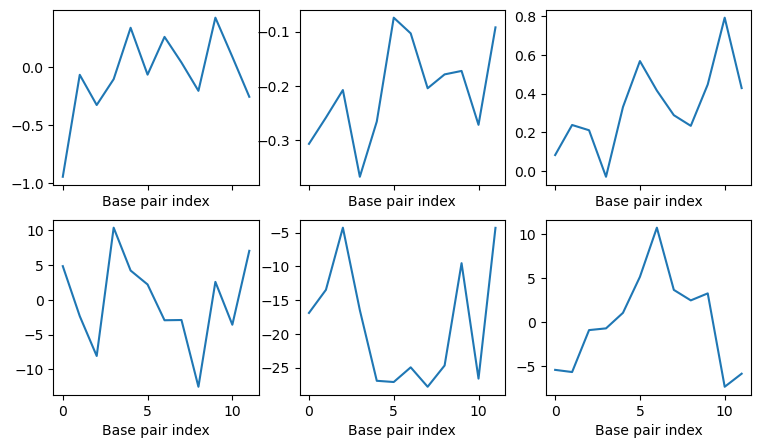

In [818]:
t = np.squeeze(T).T
r = np.squeeze(R).T

fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=True, sharey=False)
ax = ax.flatten()

# plot translation
for i in range(3):
    ax[i].plot(t[:, i])
   # ax[i].set_ylabel(f'Translation {i}')
    ax[i].set_xlabel('Base pair index')
# plot rotation
for i in range(3):
    ax[i+3].plot(np.rad2deg(r[:, i]))
    #ax[i+3].set_ylabel(f'Euler angle {i}')
    ax[i+3].set_xlabel('Base pair index')

In [823]:
T, R = [], []
print(0)
for idx in range(1, len(sequence)):
    print(idx)
    q_a, q_b = q_mid[idx-1], q_mid[idx]
    quat_a, quat_b = quat_mid[idx-1], quat_mid[idx]
    frame_a = (q_a, quat_a)
    frame_b = (q_b, quat_b)
    trans, rot, _, _ = interpolate_frames(frame_a, frame_b, t=0.5,step=True)
    T.append(trans)
    R.append(rot)
    # if idx == 5:
    #     break
T = np.array(T).swapaxes(0,2)
R = np.array(R).swapaxes(0,2)

step_T = T
step_R = R
# np.deg2rad(38), np.rad
# np.rad2deg(np.pi*2-5.735249258670459)
# (5.735249258670459 % np.pi)#%np.pi

0
1
unflipping rotors
to_axis_angle (1, 3) [[-0.06240025  0.06517303  0.76045367]]
2
unflipping rotors
to_axis_angle (1, 3) [[ 0.02617294 -0.09897296  0.62990724]]
3
unflipping rotors
to_axis_angle (1, 3) [[-0.56153024 -2.41382685 -5.17215698]]
4
unflipping rotors
to_axis_angle (1, 3) [[-0.07057329 -0.00901135  0.69396518]]
5
unflipping rotors
to_axis_angle (1, 3) [[-0.0246734   0.00487111  0.61288265]]
6
unflipping rotors
to_axis_angle (1, 3) [[ 0.04564997 -0.04775673  0.59246588]]
7
unflipping rotors
to_axis_angle (1, 3) [[ 0.05566061 -0.02459486  0.60004633]]
8
unflipping rotors
to_axis_angle (1, 3) [[ 0.03365866 -0.03696278  0.69273341]]
9
unflipping rotors
to_axis_angle (1, 3) [[-0.04463493  0.14896989  0.57252586]]
10
unflipping rotors
to_axis_angle (1, 3) [[-0.09856093 -0.26341041  0.66892969]]
11
unflipping rotors
to_axis_angle (1, 3) [[ 0.04702426 -0.024082    0.59608585]]


In [824]:
T.shape, R.shape

((3, 1, 11), (3, 1, 11))

In [825]:
np.rad2deg(np.pi)

180.0

(12,)
(12,)
(12,)
[ 0.         -0.0330007  -0.00572493  0.10912903 -0.06804928 -0.02171174
  0.02931439  0.04523933  0.01874121 -0.0006617  -0.17935186  0.03733486]
[ 0.          0.08166725 -0.10052692  0.20781143  0.01521315  0.01189845
 -0.05813793 -0.03934015 -0.04527449  0.15339133 -0.21091075 -0.03628009]
[0.         0.75960685 0.63073513 0.50782344 0.69373325 0.61278518
 0.59182527 0.59933812 0.69244996 0.57361275 0.6923087  0.59554468]


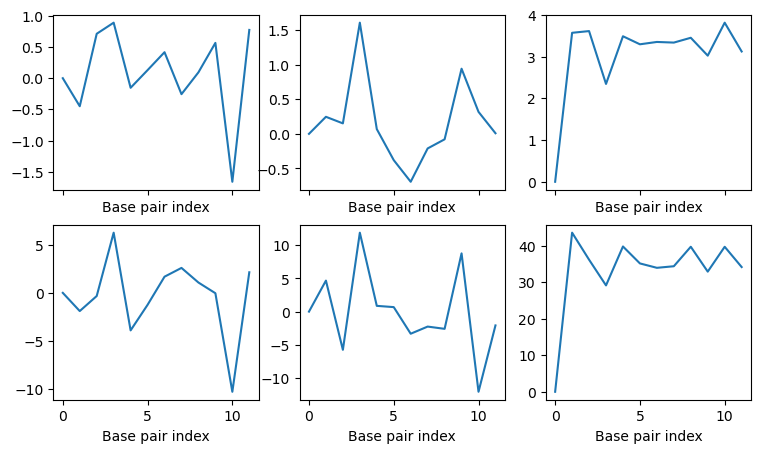

In [826]:
t = np.squeeze(T).T
r = np.squeeze(R).T

fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=True, sharey=False)
ax = ax.flatten()

# plot translation
for i in range(3):
    param = np.concatenate(([0],t[:, i]))
    print(param.shape)
    ax[i].plot(param)
   # ax[i].set_ylabel(f'Translation {i}')
    ax[i].set_xlabel('Base pair index')
# plot rotation
for i in range(3):
    #ax[i+3].plot(np.concatenate(([0],np.rad2deg(r[:, i]))))
    param = np.concatenate(([0],r[:, i]))

    print(param)
    ax[i+3].plot(np.rad2deg(param))
    #ax[i+3].set_ylabel(f'Euler angle {i}')
    ax[i+3].set_xlabel('Base pair index')

# ax[-3].set_ylim(-10,10)
# ax[-2].set_ylim(-15,15)
# ax[-1].set_ylim(-10,45)

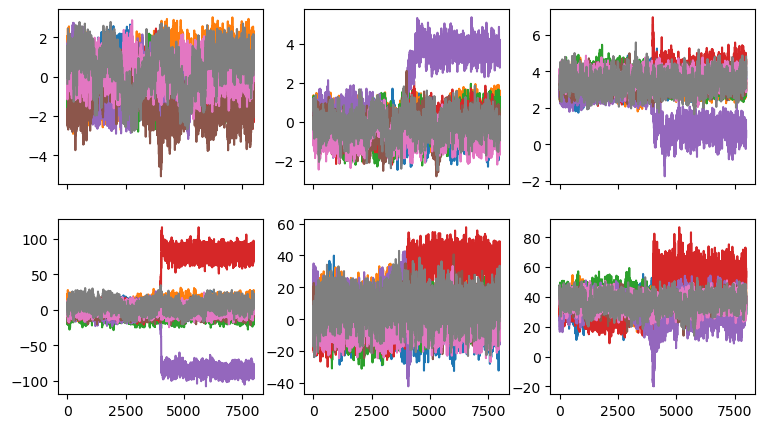

In [787]:
# shapes of R and T  (3, 170, 9)
fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=True, sharey=False)
ax = ax.flatten()
for i in range(3):
    ax[i].plot(T[i])
    ax[i+3].plot(np.rad2deg(R[i]))

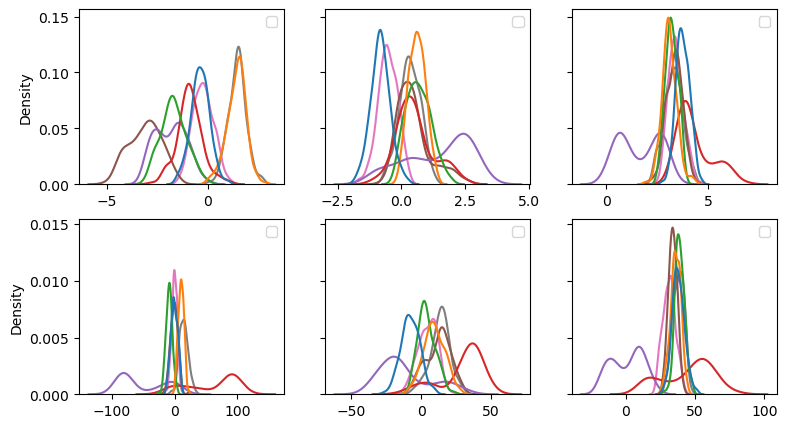

In [781]:
# shapes of R and T  (3, 170, 9)
import seaborn as sns
fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=False, sharey='row')
ax = ax.flatten()
for i in range(3):
    sns.kdeplot(T[i], ax=ax[i])
    sns.kdeplot(np.rad2deg(R[i]), ax=ax[i+3])
    ax[i].legend([])
    ax[i+3].legend([])
    # ax[i].hist(T[i],bins=40,density=True, alpha=0.5)
    # ax[i+3].hist(np.rad2deg(R[i]),bins=40)

(3, 170, 9) (3, 170, 8)
(3, 170, 1)
(3, 170, 9)


/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_68954/3228382243.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(params[i], ax=ax[i],)
/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_68954/3228382243.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(params[i], ax=ax[i],)
/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_68954/3228382243.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(params[i], ax=ax[i],)
/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_68954/3228382243.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(params[i], ax=ax[i],)
/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_6

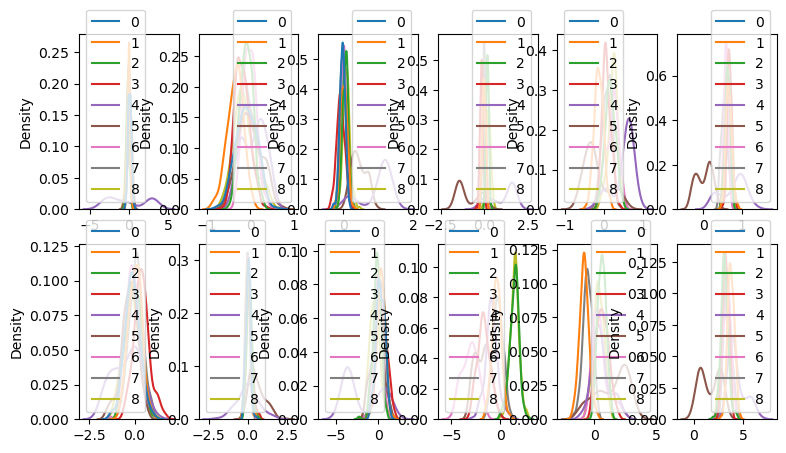

In [778]:
print(bp_T.shape, step_T.shape)
extra_column = np.zeros((3,step_T.shape[1], 1))
print(extra_column.shape)
step_T_padded = np.concatenate((extra_column,step_T), axis=-1)
print(step_T_padded.shape)
TT = np.concatenate((bp_T,  step_T_padded))

extra_column = np.zeros((3,step_R.shape[1], 1))
step_R_padded = np.concatenate((extra_column,step_R), axis=-1)
RR = np.concatenate((bp_R, step_R_padded))
TT.shape, RR.shape
params = np.concatenate((RR,TT))#.swapaxes(0,2)
params.shape

fig, ax = plt.subplots(2,6, figsize=(9, 5))
ax = ax.flatten()
for i in range(12):
    sns.kdeplot(params[i], ax=ax[i],)

In [737]:
params.shape

(12, 8000, 9)

0 (9, 8000)
1 (9, 8000)
2 (9, 8000)
3 (9, 8000)


/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_68954/3692099437.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(i, ax=ax[_], color=colors[idx], label=i)
/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_68954/3692099437.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(i, ax=ax[_], color=colors[idx], label=i)
/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_68954/3692099437.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(i, ax=ax[_], color=colors[idx], label=i)


4 (9, 8000)
5 (9, 8000)
6 (9, 8000)
7 (9, 8000)
8 (9, 8000)
9 (9, 8000)


/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_68954/3692099437.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(i, ax=ax[_], color=colors[idx], label=i)
/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_68954/3692099437.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(i, ax=ax[_], color=colors[idx], label=i)
/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_68954/3692099437.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(i, ax=ax[_], color=colors[idx], label=i)


10 (9, 8000)
11 (9, 8000)


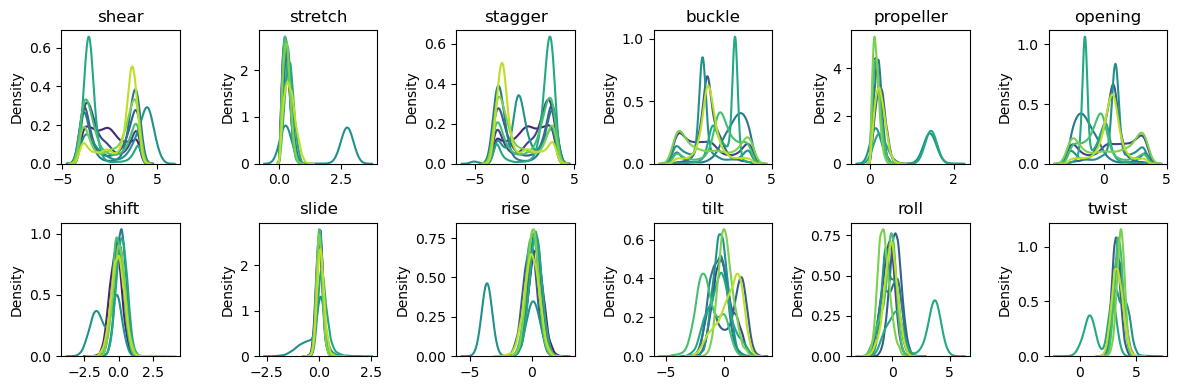

In [746]:
import seaborn as sns
fig, ax = plt.subplots(2,6, figsize=(12,4),sharex=False)
ax = ax.flatten()
colors = sns.color_palette('viridis', n_colors=9)  
for _,p in enumerate(params.swapaxes(1,2)):
    print(_,p.shape)
    for idx,i in enumerate(p):
        sns.kdeplot(i, ax=ax[_], color=colors[idx], label=i)

    ax[_].set_title(names[_])

fig.tight_layout()

In [ ]:
view = nv.show_mdtraj(traj[3955:4125].remove_solvent())    
view.clear()
view.add_representation('licorice')
view

NGLWidget(max_frame=169)

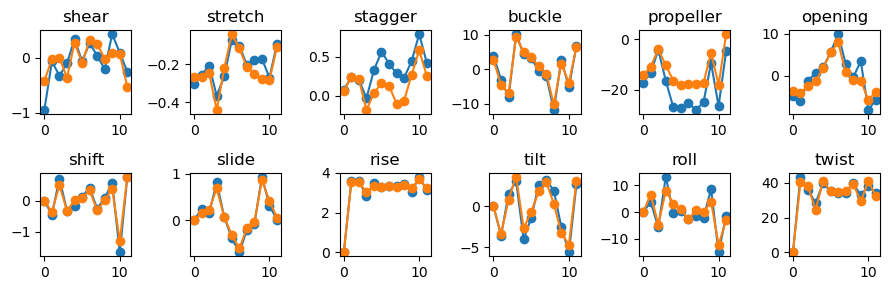

In [103]:
%matplotlib inline
pdb = md.load_pdb('./1bna.pdb')
nuc = mdna.NucleicFrames(pdb)

params, names = nuc.get_parameters()

ref = data = np.array([np.genfromtxt('./1bna_x3dna.dat', skip_header=2, usecols=range(1, 13))])

fig,ax = plt.subplots(2,6, figsize=[9,3])
ax = ax.flatten()
for _,name in enumerate(names):
    

    para = params[:,:,names.index(name)]
    ref_para = ref[:,:,names.index(name)]
    
    # if _ in [5,6,7,8,10,11]:
    #     ax[_].plot(np.mean(para, axis=0)[::-1],'-o')

    # elif _ == 9:
    #     ax[_].plot(-np.mean(para, axis=0)[::-1],'-o')
    # else:
    #     ax[_].plot(np.mean(para, axis=0),'-o')
    ax[_].plot(np.mean(para, axis=0),'-o')    
    ax[_].plot(np.mean(ref_para, axis=0),'-o')
    ax[_].set_title(name)
    
fig.tight_layout()


In [106]:
ref[0][0]

array([ -0.422,  -0.268,   0.06 ,   2.762, -14.2  ,  -3.666,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ])

In [6]:
#list(nuc.frames.keys())[0].chain.index

(0.7328599035739898,
 2.7654400527477265,
 1.479309970140457,
 3.511890119314194,
 1.9243324652314184,
 3.448767577111721)

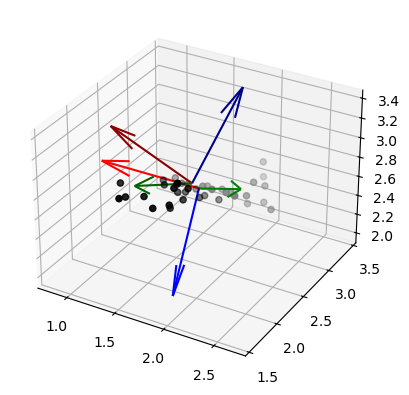

In [280]:
def plot_frame(frame,ax,colors=['r','g','b']):
    origin = frame[0]
   
    _ = 0
    for v in frame[1:]:
        ax.quiver(origin[0], origin[1], origin[2], v[0], v[1], v[2], color=colors[_],length=1)
        _ += 1

pdb = md.load_pdb('./1bna.pdb')
nuc = mdna.NucleicFrames(pdb)

# get the frames of residues A and B    
frames = nuc.frames
idx = 0
res_a,res_b = nuc.res_A[idx], nuc.res_B[idx]
frame_a, frame_b = frames[res_a][0], frames[res_b][0]


# plot boolean
residue_a = True
residue_b = True
frame_A = True
frame_B = True
other_atoms = False


# plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# plot residue A
if residue_a:
    indices = [atom.index for atom in res_a.atoms] 
    xyz = pdb.xyz[0][indices]
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='gray', marker='o')

# plot residue B
if residue_b:
    indices = [atom.index for atom in res_b.atoms]
    xyz = pdb.xyz[0][indices]
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='black', marker='o')

# other atoms
if other_atoms:
    not_xyz = pdb.xyz[0][[atom.index for atom in pdb.top.atoms if atom.index not in indices]]
    ax.scatter(not_xyz[:,0], not_xyz[:,1], not_xyz[:,2], c='k', marker='o',alpha=1,s=0.5)

# plot frames
if frame_A:
    plot_frame(frame_a, ax, colors=['r','g','b'])
if frame_B:
    #frame_b[[1,2]] *= -1
    #frame_b[[2,3]] *= -1
    plot_frame(frame_b, ax, colors=['darkred','darkgreen','darkblue'])

ax.axis('equal')

In [281]:
frame_a, frame_b

(array([[ 1.7028706 ,  2.5605135 ,  2.65188   ],
        [-0.9985314 , -0.0465459 ,  0.0277216 ],
        [-0.05410076,  0.88362384, -0.4650613 ],
        [-0.00284877, -0.46587804, -0.8848443 ]], dtype=float32),
 array([[ 1.6101896 ,  2.597042  ,  2.659227  ],
        [-0.9540921 ,  0.1555016 ,  0.25598374],
        [-0.03684354, -0.90910685,  0.4149304 ],
        [ 0.29723895,  0.38645053,  0.8731009 ]], dtype=float32))

In [277]:
frame_b

array([[ 1.6101896 ,  2.597042  ,  2.659227  ],
       [-0.9540921 ,  0.1555016 ,  0.25598374],
       [ 0.03684354,  0.90910685, -0.4149304 ],
       [-0.29723895, -0.38645053, -0.8731009 ]], dtype=float32)

In [ ]:
# [ -0.422,  -0.268,   0.06 ,   2.762, -14.2  ,  -3.666]

In [124]:

frame_a = np.array(frame_a)
frame_b = np.array(frame_b)
print(frame_a.shape, frame_b.shape)

# flip the b frame (change the signs of the vectors d2 and d3 to opposite)
# frame_b[[2,3]] *= -1

# convert {d1,d2,d3} to {d1,d2,d3} part to column vectors
d0 = frame_a[1:]
d1 = frame_b[1:]
r0 = frame_a[0]
r1 = frame_b[1]
print(d0.shape, d1.shape)
print('d0',d0)
print('d1',d1)
# now we can define the the base pair frame as the average orietnation of the two frames
# using the relative rotation matrix that rotates d0 to d1
R = d1.T @ d0
print('R',R)
G = d0@np.sqrt(R)

E = G.T * (r0-r1)
R,G,E
np.rad2deg(E)

(4, 3) (4, 3)
(3, 3) (3, 3)
d0 [[-0.9985314  -0.0465459   0.0277216 ]
 [-0.05410076  0.88362384 -0.4650613 ]
 [-0.00284877 -0.46587804 -0.8848443 ]]
d1 [[-0.9540921   0.1555016   0.25598374]
 [ 0.03684354  0.90910685 -0.4149304 ]
 [-0.29723895 -0.38645053 -0.8731009 ]]
R [[ 0.9515444   0.215442    0.21942672]
 [-0.20335568  0.9761093  -0.07653113]
 [-0.23067251  0.02820114  0.9726227 ]]


/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_34478/1114214565.py:20: RuntimeWarning: invalid value encountered in sqrt
  G = d0@np.sqrt(R)


array([[       nan,        nan,        nan],
       [-76.84812 , 106.075455, -83.7644  ],
       [       nan,        nan,        nan]], dtype=float32)

In [117]:
R

array([[ 0.9525492 ,  0.0699739 , -0.29623255],
       [-0.09060716,  0.9942833 , -0.05648907],
       [ 0.29058638,  0.08064938,  0.95344394]], dtype=float32)

In [ ]:
 -0.422,  -0.268,   0.06 ,

(11, 8)


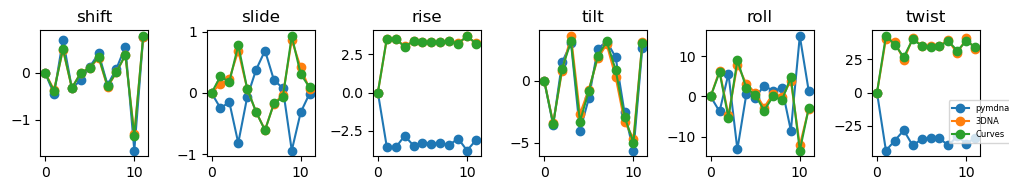

In [7]:
fig,ax = plt.subplots(1,6, figsize=[10,2])
ax = ax.flatten()

for _,name in enumerate(names[6:]):
    

    para = params[:,:,names.index(name)]
    ref_para = ref[:,:,names.index(name)]
    
    # if _ in [5,6,7,8,10,11]:
    #     ax[_].plot(np.mean(para, axis=0)[::-1],'-o')
    # elif _ == 9:
    #     ax[_].plot(-np.mean(para, axis=0)[::-1],'-o')
    # else:
    #     ax[_].plot(np.mean(para, axis=0),'-o')
    ax[_].plot(np.mean(para, axis=0),'-o')    
    ax[_].plot(np.mean(ref_para, axis=0),'-o')
    ax[_].set_title(name)



step = np.loadtxt('./output/step.dat')
print(step.shape)
extra_column = np.zeros((1, 8))
step = np.concatenate((extra_column,step), axis=0)
for i in range(0, 6):
    param = step[:, i]
    ax[i].plot(param, '-o')


fig.legend(['pymdna', '3DNA','Curves'], loc=[0.94,0.25],fontsize=6)
fig.tight_layout()

(12, 8)


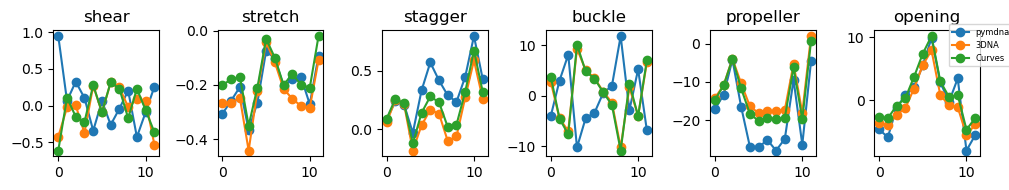

In [8]:
fig,ax = plt.subplots(1,6, figsize=[10,2])
ax = ax.flatten()

for _,name in enumerate(names[:6]):
    

    para = params[:,:,names.index(name)]
    ref_para = ref[:,:,names.index(name)]
    
    # if _ in [5,6,7,8,10,11]:
    #     ax[_].plot(np.mean(para, axis=0)[::-1],'-o')
    # elif _ == 9:
    #     ax[_].plot(-np.mean(para, axis=0)[::-1],'-o')
    # else:
    #     ax[_].plot(np.mean(para, axis=0),'-o')
    ax[_].plot(np.mean(para, axis=0),'-o')    
    ax[_].plot(np.mean(ref_para, axis=0),'-o')
    ax[_].set_title(name)



pair = np.loadtxt('./output/pair.dat')
print(step.shape)

for i in range(0, 6):
    param = pair[:, i]
    ax[i].plot(param, '-o')


fig.legend(['pymdna', '3DNA','Curves'], loc=[0.94,0.65],fontsize=6)
fig.tight_layout()